In [7]:
# import relevant libraries
%matplotlib inline

import json
import os
import sys

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
from matplotlib import transforms
import squarify


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tscraper.tscraper import get_complete_data

/Users/forons/dev/workspace/Transfermarkt


In [3]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def draw_pitch(ax, color="lightgray"):
    # size of the pitch is 120, 80
    #Create figure

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color=color)
    plt.plot([0,120],[80,80], color=color)
    plt.plot([120,120],[80,0], color=color)
    plt.plot([120,0],[0,0], color=color)
    plt.plot([60,60],[10,70], color=color)

    #Left Penalty Area
    plt.plot([14.6,14.6],[57.8,22.2],color=color)
    plt.plot([0,14.6],[57.8,57.8],color=color)
    plt.plot([0,14.6],[22.2,22.2],color=color)

    #Right Penalty Area
    plt.plot([120,105.4],[57.8,57.8],color=color)
    plt.plot([105.4,105.4],[57.8,22.5],color=color)
    plt.plot([120, 105.4],[22.5,22.5],color=color)

    #Left 6-yard Box
    plt.plot([0,4.9],[48,48],color=color)
    plt.plot([4.9,4.9],[48,32],color=color)
    plt.plot([0,4.9],[32,32],color=color)

    #Right 6-yard Box
    plt.plot([120,115.1],[48,48],color=color)
    plt.plot([115.1,115.1],[48,32],color=color)
    plt.plot([120,115.1],[32,32],color=color)

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color=color,fill=False)
    centreSpot = plt.Circle((60,40),0.71,color=color)
    leftPenSpot = plt.Circle((9.7,40),0.71,color=color)
    rightPenSpot = plt.Circle((110.3,40),0.71,color=color)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color=color)
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color=color)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Referee Area
    plt.plot([45,75],[10,10],color=color)
    plt.plot([45,45],[0.2,10],color=color)
    plt.plot([75,75],[0.2,10],color=color)
    #Coach Area
    plt.plot([45,75],[70,70],color=color)
    plt.plot([45,45],[70,79.8],color=color)
    plt.plot([75,75],[70,79.8],color=color)
    
    
def rainbow_text(x, y, strings, font_colors, font_weights=None, font_sizes=None,
                 orientation='horizontal', ax=None, sep="\n", **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transAxes
    canvas = ax.figure.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for idx, (s, c) in enumerate(zip(strings, font_colors)):
        if font_weights:
            weight = font_weights[idx]
            if font_sizes:
                size = font_sizes[idx]
                text = ax.text(x, y, s + sep, fontweight=weight, fontsize=size, color=c, transform=t, **kwargs)
            else:
                text = ax.text(x, y, s + sep, fontweight=weight, color=c, transform=t, **kwargs)
        elif font_sizes:
            size = font_sizes[idx]
            text = ax.text(x, y, s + sep, fontsize=size, color=c, transform=t, **kwargs)
        else:
            text = ax.text(x, y, s + sep, color=c, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal' and sep == "\n":
            print('Error here')
            t = transforms.offset_copy(
                text.get_transform(), y=-ex.height/1.5, units='dots')
        elif orientation == 'horizontal':
            print('HEREEEEEEE')
            t = transforms.offset_copy(
                text.get_transform(), x=ex.width, units='dots')
        else:
            t = transforms.offset_copy(
                text.get_transform(), y=ex.height, units='dots')

In [61]:
def print_bench(df, team, ax, pos='left', comp=None):
    team_name = team[0][0]['team']
    df_team = df[(df['is_bench'] == True) & (df['team'] == team_name)]
    for idx, (_, player) in enumerate(df_team.iterrows()):
        age_data = ' | '.join([player['age'].split(' ')[0], player['birth_date'].split(' ')[-1], player['country'].capitalize()[:3]])
        data = [str(player['number']), player['full_name'], age_data]
        font_colors = ["red", "black", "blue"]
        font_sizes = [14, 14, 14]
        font_weights = ['extra bold', 'black', 'black']
        coord_x = 0.0
        if pos == 'right':
            coord_x = 0.5
        coord_y = 1 - idx / len(df_team)
        rainbow_text(coord_x, coord_y, sep=' || ', strings=data, font_colors=font_colors, ax=ax, font_sizes=font_sizes, font_weights=font_weights)

        nat_pres = player['nat_presences']
        nat_goals = player['nat_goals']
        nat_assists = player['nat_assists']
        season_pres = 0
        season_goals = 0
        season_assists = 0
        for key, value in player['year_summary_data'].items():
            if value[0] != '-':
                season_pres += int(value[0])
            if value[1] != '-':
                season_goals += int(value[1])
            if value[2] != '-':
                season_assists += int(value[2])
        nat_data = 'NAT: ' + ' | '.join([str(elem) for elem in [nat_pres, nat_goals, nat_assists]])
        season_data = 'SEA: ' + ' | '.join([str(elem) for elem in [season_pres, season_goals, season_assists]])
        data = [nat_data, season_data]
        font_colors = ["blue", "green", "blue"]
        font_sizes = [12, 12]
        font_weights = ['normal', 'normal', 'normal']
        if comp and comp in player['year_summary_data']:
            comp_data = player['year_summary_data'][comp]
            comp_str = 'COMP: ' + ' | '.join([str(comp_data[0]), str(comp_data[1]), str(comp_data[2])])
            data.append(comp_str)
            font_colors.append("green")
            font_sizes.append(12)
            font_weights.append("normal")
        coord_x = 0.05
        if pos == 'right':
            coord_x = 0.55
        coord_y -= 0.025
        rainbow_text(coord_x, coord_y, sep=' ---- ', strings=data, font_colors=font_colors, ax=ax, font_sizes=font_sizes, font_weights=font_weights)

In [66]:
def print_team(df, team, ax, pos='left', coach=None, comp=None):
    total_lines = len(team)
    for x_idx, line in enumerate(team):
        players_in_line = len(line)
        for y_idx, player in enumerate(line):
            nat_pres = player['nat_presences']
            nat_goals = player['nat_goals']
            nat_assists = player['nat_assists']
            season_pres = 0
            season_goals = 0
            season_assists = 0
            for key, value in player['year_summary_data'].items():
                if value[0] != '-':
                    season_pres += int(value[0])
                if value[1] != '-':
                    season_goals += int(value[1])
                if value[2] != '-':
                    season_assists += int(value[2])
            age_data = ' | '.join([player['age'].split(' ')[0], player['birth_date'].split(' ')[-1], player['country'].capitalize()[:3]])
            nat_data = ' | '.join([str(elem) for elem in [nat_pres, nat_goals, nat_assists]])
            season_data = ' | '.join([str(elem) for elem in [season_pres, season_goals, season_assists]])
            data = [str(player['number']), player['full_name'], age_data, nat_data, season_data]
            font_colors = ["red", "black", "blue", "green", "blue"]
            font_sizes = [14, 14, 14, 12, 12]
            font_weights = ['extra bold', 'black', 'black', 'normal', 'normal']
            if comp and comp in player['year_summary_data']:
                comp_data = player['year_summary_data'][comp]
                comp_str = ' | '.join([str(comp_data[0]), str(comp_data[1]), str(comp_data[2])])
                data.append(comp_str)
                font_colors.append("green")
                font_sizes.append(12)
                font_weights.append("normal")
            coord_x = 0.05 + 0.5 * x_idx / total_lines
            coord_y = y_idx / players_in_line + (1 / players_in_line) / 2
            if x_idx == 3:
                coord_y = min(coord_y, 0.75)
                coord_y = max(coord_y, 0.25)
            if pos == 'right':
                coord_x = 1 - coord_x
                coord_y = 1 - coord_y
            rainbow_text(coord_x, coord_y, strings=data, font_colors=font_colors, ax=ax, font_sizes=font_sizes, font_weights=font_weights, ha='center', va='center')
    if coach:
        coord_x = 0.45
        if pos == 'right':
            coord_x = 1 - coord_x
        rainbow_text(coord_x, 0.075, strings=[coach], font_colors=["black"], ax=ax, font_sizes=["14"], font_weights=["extra bold"], ha='center', va='center')


In [70]:
def print_referee(data):
    font_colors = ["red", "black", "blue", "black", "blue"]
    font_sizes = [14, 10, 10, 10, 10]
    font_weights = ['extra bold', 'black', 'normal', 'normal', 'normal']
    coord_x = 0.5
    coord_y = 0.98
    rainbow_text(coord_x, coord_y, strings=data, font_colors=font_colors, ax=ax, font_sizes=font_sizes, font_weights=font_weights, ha='center', va='center')

In [7]:
def get_team(team_data, team_modulo):
    goalkeeper = team_data[0]
    team_lines = [int(line) for line in team_modulo.split('-')]
    data_lines = []
    data_lines.append([goalkeeper])
    idx = 1
    for line in team_lines:
        data_lines.append(team_data[idx:idx + line])
        idx += line
    return data_lines

In [8]:
def get_team_data(team_data, team_id):
    team_names = [name for name, _ in team_data]
    team_numbers = [number for _, number in team_data]
    total_team_data = get_complete_data(team_names, lookup_date=match_date)
    for idx, (elem, number) in enumerate(zip(total_team_data, team_numbers)):
        elem['number'] = number
        elem['which_team'] = team_id
        if idx < 11:
            elem['is_bench'] = False
        else:
            elem['is_bench'] = True
    return total_team_data

### Match Data

In [59]:
match_date = '09/05/2018'
competition = 'Coppa Italia'
home_team_name = 'juventus'
away_team_name = 'milan'
home_team_modulo = '4-3-3'
away_team_modulo = '4-3-3'

In [10]:
home_team = [
    ('Gianluigi Buffon', 1),
    ('Juan Cuadrado', 6),
    ('Andrea Barzagli', 15),
    ('Medhi Benatia', 4),
    ('Kwadwo Asamoah', 22),
    ('Sami Khedira', 6),
    ('Miralem Pjanic', 8),
    ('Blaise Matuidi', 14),
    ('Paulo Dybala', 10),
    ('Mario Mandzukic', 17),
    ('Douglas Costa', 11),
    ('Carlo Pinsoglio', 16),
    ('Wojciech Szczesny', 23),
    ('Mattia De Sciglio', 2),
    ('Claudio Marchisio', 8),
    ('Gonzalo Higuain', 9),
    ('Alex Sandro', 12),
    ('Benedikt Howedes', 21),
    ('Daniele Rugani', 24),
    ('Stephan Lichtsteiner', 26),
    ('Stefano Sturaro', 27),
    ('Rodrigo Bentancur', 30),
    ('Federico Bernardeschi', 33)
]

away_team = [
    ('Gianluigi Donnarumma', 1),
    ('Davide Calabria', 2),
    ('Leonardo Bonucci', 19),
    ('Alessio Romagnoli', 13),
    ('Ricardo Rodriguez', 68),
    ('Franck Kessie', 79),
    ('Manuel Locatelli', 73),
    ('Giacomo Bonaventura', 5),
    ('Suso', 8),
    ('Patrick Cutrone', 63),
    ('Hakan Calhanoglu', 10),
    ('Marco Storari', 30),
    ('Antonio Donnarumma', 90),
    ('Jose Mauri', 4),
    ('Nikola Kalinic', 7),
    ('Andre Silva', 9),
    ('Fabio Borini', 11),
    ('Cristian Zapata', 17),
    ('Riccardo Montolivo', 18),
    ('Ignazio Abate', 20),
    ('Lucas Biglia', 21),
    ('Mateo Musacchio', 22),
    ('Luca Antonelli', 31)
]

### Get data in Pandas dataframe

In [11]:
home_team_data = get_team_data(home_team, team_id=0)
away_team_data = get_team_data(away_team, team_id=1)

In [12]:
total_data = []
total_data.extend(home_team_data)
total_data.extend(away_team_data)

df = pd.DataFrame(total_data)
df

,full_name,id,ref_url,nat_presences,nat_goals,nat_assists,nat_goals_against,birth_date,age,country,team,time_in_team,year_summary_data,team_goals_against,number,which_team,is_bench
0,Gianluigi Buffon,5023,gianluigi-buffon,175,0,0,"{'russia': 0, 'paraguay': 0, 'switzerland': 0,...","Jan 28, 1978",40 years ago,ITA,Juventus,16 years ago,"{'Serie A': ('21', '-', '1', '-', '-', '14'), ...","{'fc barcelona': 0, 'olympiacos': 0, 'sporting...",1,0,False
1,Juan Cuadrado,91970,juan-cuadrado,68,7,11,"{'venezuela': 1, 'mexico': 1, 'ecuador': 1, 'u...","May 26, 1988",29 years ago,COL,Juventus,11 months ago,"{'Serie A': ('21', '4', '7', '5', '-', '-'), '...","{'olympiacos': 1, 'sporting cp': 0, 'fc barcel...",6,0,False
2,Andrea Barzagli,7109,andrea-barzagli,73,0,0,"{'finland': 0, 'iceland': 0, 'serbia-mont.': 0...","May 8, 1981",37 years ago,ITA,Juventus,7 years ago,"{'Serie A': ('25', '-', '1', '2', '-', '-'), '...","{'fc barcelona': 0, 'olympiacos': 0, 'sporting...",15,0,False
3,Medhi Benatia,45124,medhi-benatia,46,2,1,"{'cameroon': 0, 'togo': 0, 'gabon': 0, 'equat....","Apr 17, 1987",31 years ago,MAR,Juventus,11 months ago,"{'Serie A': ('20', '2', '-', '8', '-', '-'), '...","{'fc barcelona': 0, 'olympiacos': 0, 'sporting...",4,0,False
4,Kwadwo Asamoah,63531,kwadwo-asamoah,0,0,0,{},"Dec 9, 1988",29 years ago,GHA,Juventus,5 years ago,"{'Serie A': ('19', '-', '-', '4', '-', '-'), '...","{'spurs': 0, 'real madrid': 0, 'chievo verona ...",22,0,False
5,Sami Khedira,29401,sami-khedira,73,7,9,"{'south africa': 0, 'argentina': 0, 'malta': 0...","Apr 4, 1987",31 years ago,DEU,Juventus,2 years ago,"{'Serie A': ('26', '9', '2', '1', '-', '-'), '...","{'sporting cp': 0, 'fc barcelona': 0, 'olympia...",6,0,False
6,Miralem Pjanic,44162,miralem-pjanic,77,11,25,"{'bulgaria': 0, 'spain': 0, 'estonia': 0, 'tur...","Apr 2, 1990",28 years ago,Bosnia-Herzegovina,Juventus,2 years ago,"{'Serie A': ('31', '5', '8', '5', '-', '-'), '...","{'fc barcelona': 0, 'sporting cp': 1, 'olympia...",8,0,False
7,Blaise Matuidi,33923,blaise-matuidi,64,9,7,"{'bosnia': 0, 'croatia': 0, 'ukraine': 0, 'chi...","Apr 9, 1987",31 years ago,FRA,Juventus,9 months ago,"{'Serie A': ('32', '3', '1', '3', '-', '-'), '...","{'fc barcelona': 0, 'olympiacos': 0, 'sporting...",14,0,False
8,Paulo Dybala,206050,paulo-dybala,12,0,1,"{'paraguay': 0, 'brazil': 0, 'colombia': 0, 'u...","Nov 15, 1993",24 years ago,ARG,Juventus,2 years ago,"{'Serie A': ('33', '22', '5', '-', '-', '-'), ...","{'fc barcelona': 0, 'olympiacos': 0, 'sporting...",10,0,False
9,Mario Mandzukic,34572,mario-mandzukic,82,30,8,"{'macedonia': 0, 'england': 1, 'ukraine': 0, '...","May 21, 1986",31 years ago,HRV,Juventus,2 years ago,"{'Serie A': ('32', '5', '2', '3', '1', '-'), '...","{'olympiacos': 1, 'sporting cp': 1, 'spurs': 0...",17,0,False


In [13]:
keys = set()
for idx, row in df.iterrows():
    for key in row['year_summary_data'].keys():
        keys.add(key)


first_row = ['NomeCognome']
for key in keys:
    first_row.extend(['Presenze', 'Gol', 'Assist', 'Gialli', 'DoppiGialli', 'Rossi', 'GolConcessi'])

print('\t'.join(key.replace(' ', '') for key in keys))
print('\t'.join(first_row))
        
for idx, row in df.iterrows():
    player_row = [row['ref_url']]
    for key in keys:
        v1, v2, v3, v4, v5, v6 = row['year_summary_data'].get(key, ('-', '-', '-', '-', '-', '-'))
        player_row.extend([v1, v2, v3, v4, v5, v6, v6])
    print('\t'.join(player_row))

ChampionsLeague	Ligue1	CoppaItalia	TrophéedesChampions	Bundesliga	EuropaLeague	EuropaLeagueQualifying	SupercoppaItaliana	SerieA
NomeCognome	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi	Presenze	Gol	Assist	Gialli	DoppiGialli	Rossi	GolConcessi
gianluigi-buffon	9	-	-	-	1	11	11	-	-	-	-	-	-	-	3	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	1	-	1	-	-	3	3	21	-	1	-	-	14	14
juan-cuadrado	6	1	1	1	-	-	-	-	-	-	-	-	-	-	1	-	1	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	-	1	-	-	-	-	-	-	21	4	7	5	-	-	-
andrea-barzagli	8	-	-	1	-	-	-	-	-	-	-	-	-	-	4	-	-	-	-	-	-	

### Plot data

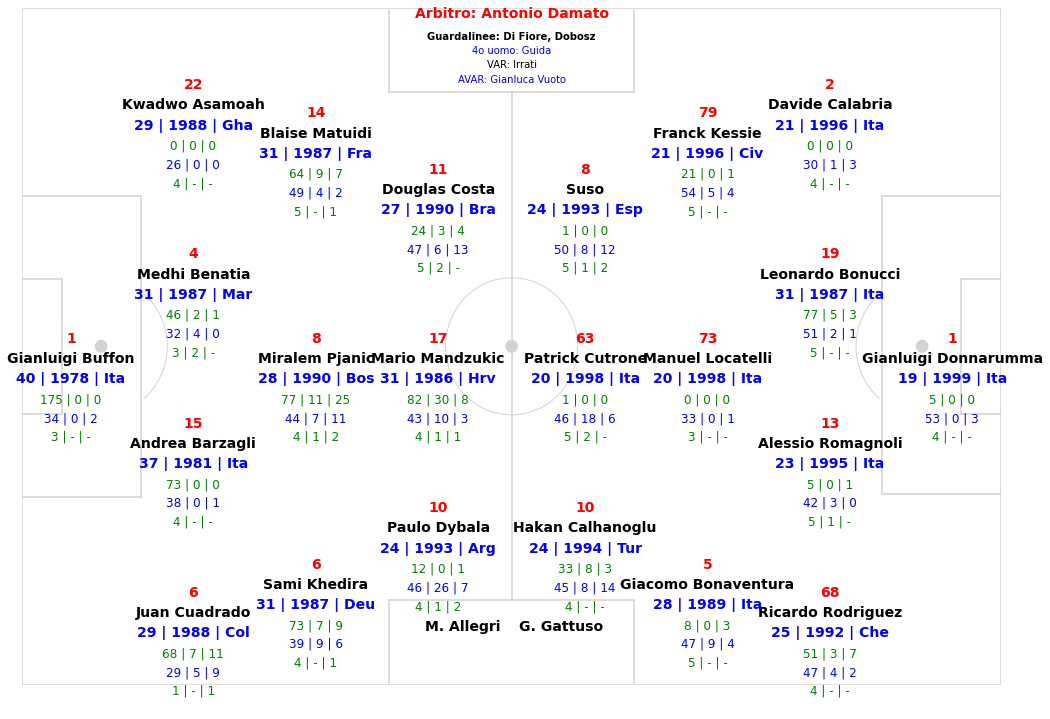

In [71]:
fig = plt.figure()
fig.set_size_inches(1.5 * 11.7, 1.5 * 8.3)
ax = fig.add_subplot(1,1,1)
draw_pitch(ax)

plt.axis('off')

home_team = get_team(team_data=home_team_data, team_modulo=home_team_modulo)
away_team = get_team(team_data=away_team_data, team_modulo=away_team_modulo)

print_team(df=df, team=home_team, ax=ax, pos='left', comp=competition, coach="M. Allegri")
print_team(df=df, team=away_team, ax=ax, pos='right', comp=competition, coach="G. Gattuso")
print_referee(["Arbitro: Antonio Damato", "Guardalinee: Di Fiore, Dobosz", "4o uomo: Guida", "VAR: Irrati", "AVAR: Gianluca Vuoto"])

plt.ylim(0, 80)
plt.xlim(0, 120)
plt.savefig(f'{home_team_name}-{away_team_name}_finale_coppa_italia.pdf')
plt.show()

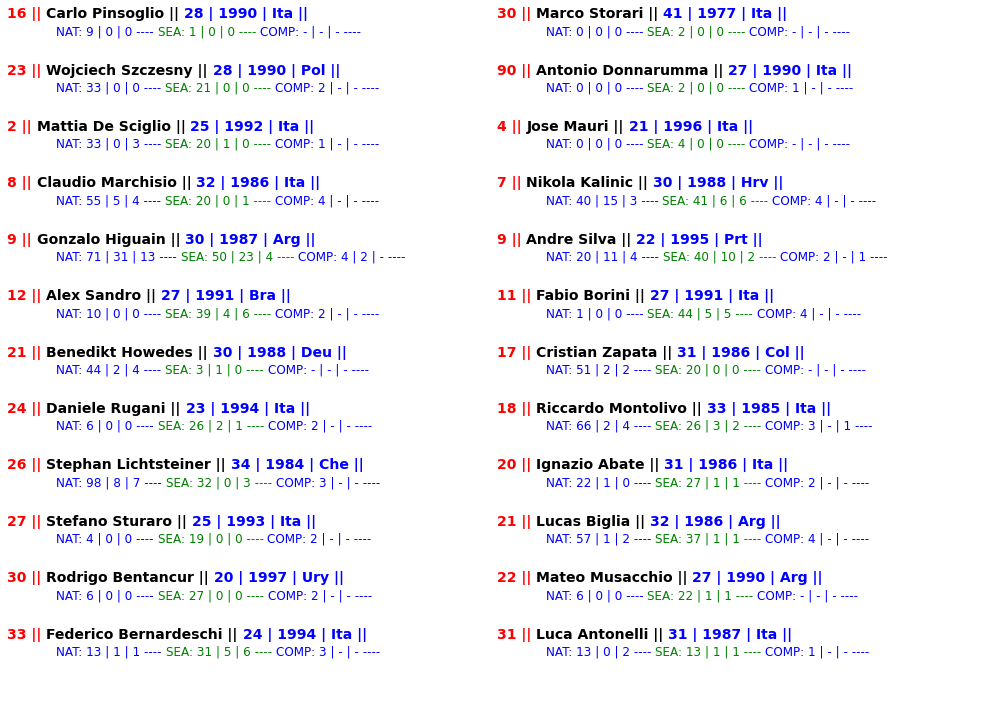

In [63]:
fig1 = plt.figure()
fig1.set_size_inches(1.5 * 11.7, 1.5 * 8.3)
ax1 = fig1.add_subplot(1,1,1)

plt.axis('off')

print_bench(df=df, team=home_team, ax=ax1, comp=competition, pos='left')
print_bench(df=df, team=away_team, ax=ax1, comp=competition, pos='right')

plt.ylim(0, 80)
plt.xlim(0, 120)
plt.savefig(f'{home_team_name}-{away_team_name}_finale_coppa_italia_subs.pdf')
plt.show()